In [1]:
import numpy as np
import scipy.io
from scipy import stats
from copy import copy
import matplotlib.pyplot as plt
import scipy as sp
import scipy.optimize as spo
from sklearn.linear_model import ElasticNet
import numpy.linalg as npl
import numpy.random as npr
from scipy.stats.mstats import linregress
from sklearn.decomposition import PCA
root2over = 1/np.sqrt(2)
erf_max = sp.special.erf(root2over)

#function to standardize the MEG data matrices, which have very small values around e-13, e-14
def standardize(data_matrix):
    #create a copy of the data_matrix and make it normalized_sensor_matrix, will just replace values in row during loop
    x = data_matrix[:]
    x-=np.mean(x) # the -= means can be read as x = x- np.mean(x)
    x/=np.std(x) # the /= means can be read as x = x/np.std(x)
    return x

# helper function to store all the sensor labels across patients present in the total dataset
def store_labels(sensor_labels, patient):
    all_sensor_labels = []
    for i in range(sensor_labels.shape[0]):
        new_tag = sensor_labels[i][0][0]+"_"+patient
        all_sensor_labels.append(new_tag)
    return all_sensor_labels

def store_reg_labels(sensor_labels, patient):
    all_sensor_labels = []
    for i in range(sensor_labels.shape[0]):
        new_tag = sensor_labels[i][0][0]
        all_sensor_labels.append(new_tag)
    return all_sensor_labels

#function to load the MEG data from an array with all the patient ids. Returns the raw and normalized MEG data
def load_sensor_matrix(id_list):
    labels_dict = {}
    separated_dataset = {}
    first_iteration = True   #boolean value that accomodates the first run through of MEG data
    for patient in id_list:
        data = scipy.io.loadmat('HCP_dataset/'+patient+'/MEG/Restin/rmegpreproc/'+patient+'_MEG_3-Restin_rmegpreproc.mat')
        data_times = data['data'][0][0][5][:]    #extracts the timecourses of the MEG data
        data_labels = data['data'][0][0][6][:]  #extracts the sensor labels for the MEG data
        data_trials = data['data'][0][0][4][:]   #extracts the MEG potentials over the given timecourse
        separated_dataset[patient] = data_trials[0][0]
        if first_iteration:
            sensor_matrix = data_trials[0][0][:]
            first_iteration = False    #no longer in the first iteration of the loop, set to false
        else:
            #if not in the first run through, append the matrices together, to form a combined matrix
            sensor_matrix = np.concatenate((sensor_matrix, data_trials[0][0][:]), axis = 0)
        #create an array with all the sensor_labels for every patient in the dataset
        all_data_labels = store_labels(data_labels, patient)
        labels_dict[patient] = set(store_reg_labels(data_labels, patient))
    return sensor_matrix, separated_dataset, all_data_labels, labels_dict

def common_labels(labels_dict):
    s = set()
    labels_dict_values = list(labels_dict.values())
    for index in range(len(labels_dict_values)-1):
        if bool(s) == False:
            s = set(labels_dict_values[index]).intersection(labels_dict_values[index+1])
        else:
            s = s.intersection(set(labels_dict_values[index+1]))
    return s

def form_dataset(common_labels_set, separated_dataset, labels_dict):
    streamlined_dataset = {}
    for patient in separated_dataset:
        for label in common_labels_set:
            channel_number = list(labels_dict[patient]).index(label)
            if patient not in streamlined_dataset:
                streamlined_dataset[patient] = [separated_dataset[patient][channel_number, :]]
            else:
                streamlined_dataset[patient].append(separated_dataset[patient][channel_number, :])
    return streamlined_dataset

def find_sigma(y,h):
    time_steps,size = y.shape
    sigma = np.std(y-h,axis=0)
    #     sigma = np.random.rand(1,size) + 0.5
    #     for index in range(size):
    #         def f0(sig):
    #             return (1-np.std(y[:,index]/np.abs(sig) - h[:,index]))**2
    #         res = spo.minimize(f0,sigma[0,index])
    #         sigma[0,index] = np.abs(res.x)
    return(sigma.reshape(1,size))

def time_shift_cov(x,shift=1):
    time_steps,size = x.shape
    x0 = (x - np.mean(x,axis=0))/np.std(x,axis=0)
    return x0[shift:].T.dot(x0[:-shift])/np.float(time_steps-shift)

def enet_solve(c,b):
    regr = ElasticNet(random_state=0,max_iter=10000)
    regr.fit(c,b)
    return regr.coef_

def moving_avg(a,window):
    cu = np.cumsum(a,axis=0,dtype=float)
    cu[window:] = cu[window:] - cu[:-window]
    return cu[window-1:]/window

def odd_power(h,power=3):
    sign = np.sign(h)
    return sign*np.power(np.abs(h),1/power)

#Now add in a bias
def simulate(size,time_steps,w = 0.0,sigma = 1.0,coupling = 1.0,rho = 0.2,power=1,delta = 1,bias=0, initial=0):
    if npl.norm(w)==0.:
        sigma = (npr.rand(1,size)+1)/2.0        
        delta = odd_power(npr.rand(1,size)+1,power)        
        bias = (npr.rand(1,size)-0.5)*2
        w = npr.rand(size,size) - 0.5
        w = coupling*w - rho*np.eye(size)
    x = np.zeros((time_steps,size))
    x_min = np.zeros((1,size))
#     if initial == 0:
#         x[0] = npr.rand(1,size)-0.5
#     else:
    x[0] = initial

    for i in range(time_steps-1):
        x[i+1] = (1)*x[i] + delta * odd_power(bias + x[i].dot(w),power) + sigma*npr.normal(size=(1,size))
    y = np.diff(x,axis=0)
    y_max = np.max(np.abs(y),axis=0)
    opd = odd_power(delta,1/power)
    if not np.isscalar(delta):
        opd = odd_power(delta,1/power)
        return x,opd[0][None,:]*w,sigma,opd*bias
    else:
        return x,w,sigma,bias

def bias_update(y,h,b_in,pp):
    y_plus = y>0
    def f0(bias):
        return np.mean(y[y_plus]-odd_power(bias + h[y_plus],pp))**2 + np.mean(y[~y_plus]-odd_power(bias + h[~y_plus],pp))**2
    res = spo.minimize(f0,b_in)
    return res.x


def infer(x,max_iter = 100,tol=1e-8,func=npl.solve,window=1,power=1,verbose=False):
    time_steps,size = x.shape
    x0 = np.copy(x)
    if window>1:
        x0 = moving_avg(x0,window)
        time_steps = time_steps-window+1
    y = np.diff(x0,axis=0)
    y_mean = np.mean(np.abs(y),axis=0)
    y_max = np.max(np.abs(y),axis=0)
#     if power<3:
#         y /= y_max[None,:]#now y is definitely within +/- 1
#         x0 = x0/y_max[None,:]
    x0 = x0[:-1]
    s = np.sign(y)
    c = np.cov(x0,rowvar=False)
    w = npr.rand(size,size) - 0.5
    bias = npr.rand(1,size) - 0.5
    h = odd_power(bias + x0.dot(w),power)
    for index in range(size):
        err_old,error,counter = 0,np.inf,0
        #         print(index)
        while np.abs(error-err_old) > tol and counter < max_iter:
            counter += 1
            zeros = np.abs(bias[0,index] + x0.dot(w[:,index])) < 1e-7
            ratio = np.sqrt(np.pi/2.0)*np.ones((time_steps-1))*h[:,index]**(power-1)
            ratio[~zeros] = (bias[0,index] + x0[~zeros,:].dot(w[:,index]))/sp.special.erf(h[~zeros,index]*root2over)
            w[:,index] = func(c+0.1*np.eye(size),np.mean((x0-np.mean(x0,axis=0)[None,:])*(s[:,index]*ratio)[:,np.newaxis],axis=0))
            h_temp = x0.dot(w[:,index])
            bias[0,index] = bias_update(y[:,index],h_temp,bias[0,index],pp=power)
            err_old = error
            h[:,index] = odd_power(bias[0,index] + h_temp,power)
            error = npl.norm(s[:,index]-sp.special.erf(h[:,index]*root2over))
#             print(counter,error)
    sigma = find_sigma(y,h)*np.sqrt(window)#*y_max[None,:]
    return w,sigma,bias

def pca_combine_datasets(streamlined_dataset):
    pca_combined_dataset = np.array([])
    for patient in streamlined_dataset:
        x = np.asarray(streamlined_dataset[patient])
        if pca_combined_dataset.size == 0:
            pca_combined_dataset = x
        else:
            pca_combined_dataset = np.concatenate((pca_combined_dataset, x), axis=1 )
    return pca_combined_dataset

def calculate_allW(dataset, given_power):
    allwmatrices = {}
    allsigs = {}
    allbiases = {}
    for patient in dataset:
        w, sig, bias = infer(dataset[patient].transpose(), power=given_power)
        allwmatrices[patient] = w
        allsigs[patient] = sig
        allbiases[patient] = bias
    return allwmatrices, allsigs, allbiases

def calculate_allTimeCov(dataset, time_shift):
    alltimeshiftcov = {}
    for patient in dataset:
        timeshiftcovmatrix = time_shift_cov(dataset[patient].transpose(), shift=time_shift)
        alltimeshiftcov[patient] = timeshiftcovmatrix
    return alltimeshiftcov

def hcp_inference(dataset_ids, pca_components, time_shift, power):
    print("Running Newest Inference Linear with Power Fixed:")
    print("1. PCA components =", pca_components)
    print("2. Time shifts =", time_shift)
    print("3. Power =", power)
    sensor_matrix, separated_dataset, all_data_labels, labels_dict = load_sensor_matrix(dataset_ids)
    common_labels_set = common_labels(labels_dict.copy())
    streamlined_dataset = form_dataset(common_labels_set.copy(), separated_dataset.copy(), labels_dict.copy())
    normalized_streamlined_dataset = {}
    for patient in streamlined_dataset:
        normalized_streamlined_dataset[patient] = standardize(streamlined_dataset[patient])
    pca_data_dict = {}
    pca_combined_dataset = pca_combine_datasets(normalized_streamlined_dataset.copy())
    pca = PCA(n_components=pca_components)
    pca.fit(pca_combined_dataset.T)
    transformed_data = pca.fit_transform(pca_combined_dataset.T)
    counter = 0
    for patient in normalized_streamlined_dataset:
        pca_data_dict[patient] = transformed_data[counter*1018:1018*(counter+1), :].T
        counter = counter + 1
    allwmatrices, allsigs, allbiases = calculate_allW(pca_data_dict, power)
    alltscmatrices = calculate_allTimeCov(pca_data_dict, time_shift)
    return allwmatrices, alltscmatrices, allsigs, allbiases, pca_data_dict

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.mstats import linregress
%matplotlib inline

In [3]:
power = 1
pca_components = 10
time_shift = 10
dataset_ids = ['100307', '102816', '105923', '106521', '108323', '109123', '111514', '112920', 
               '116524', '116726', '133019', '140117', '146129', '149741', '153732', '154532', 
               '156334', '158136', '162026', '162935', '164636', '166438', '169040', '172029', 
               '174841', '175237', '175540', '177746', '179245', '181232', '185442', '187547', 
               '189349', '191033', '191437', '191841', '192641', '195041', '198653', '204521', 
               '205119', '212318', '212823', '214524', '221319', '223929', '233326', '248339', 
               '250427', '255639', '257845', '283543', '287248', '293748', '352132', '352738', 
               '353740', '358144', '406836', '433839', '512835', '555348', '559053', '568963', 
               '581450', '599671', '601127', '660951', '662551', '665254', '667056', '679770', 
               '680957', '706040', '707749', '715950', '725751', '735148', '783462', '814649',
               '825048', '872764', '877168', '891667', '898176', '912447', '917255', '990366']

In [4]:
allwmatrices, alltscmatrices, allsigs, allbiases, pca_data_dict = hcp_inference(dataset_ids, pca_components, time_shift, power)

Running Newest Inference Linear with Power Fixed:
1. PCA components = 10
2. Time shifts = 10
3. Power = 1


In [5]:
# allwmatrices is a dictionary with patient identifiers as keys. allwmatrices[key] will return the w matrix 
# for that specific patient
slope_average = 0
pvalue_nonlinear_average = 0
pvalue_linear_10trials = []
counter = 0
pvalue_bytimeshift = []
timeshifts = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for timeshift in timeshifts:
    for i in range(20):
        pvalue_linear_array = []
        for patient in allwmatrices:
            w = allwmatrices[patient]
            sig = allsigs[patient]
            bias = allbiases[patient]

            x_original = pca_data_dict[patient].T.copy()

            # simulate MEG timecourse data using the w, sigma, and bias computed from the inference code
            simulated_data = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, power=1, bias=bias, initial=x_original[0])

            # compute the time shift covariance matrices for the 'original' (transformed PCA MEG timecourse) and simulated data
            tsc_original = time_shift_cov(x_original, shift=timeshift)
            tsc_simulated = time_shift_cov(simulated_data[0], shift=timeshift)


            line_object = linregress(tsc_original, tsc_simulated)
    #         plt.title('Patient ' + str(patient))
    #         plt.xlabel('time_shift_cov original')
    #         plt.ylabel('time_shift_cov simulated')
    #         plt.plot(tsc_original, tsc_simulated, 'ko', alpha=0.5)
    #         plt.plot([-1, 1], [-1,1], 'r--')
    #         time_shift_axes = np.arange(-1, 2)
    #         plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--')
    #         plt.show()
    #         print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
    #         print("--------------------------------------------------------------")
            pvalue_nonlinear_average += line_object.pvalue
            pvalue_linear_array.append(line_object.pvalue)
            slope_average += line_object.slope
            counter += 1
        pvalue_linear_10trials.append(np.mean(pvalue_linear_array))
    print('mean', np.mean(pvalue_linear_10trials))
    print('std', np.std(pvalue_linear_10trials))
    pvalue_bytimeshift.append(np.mean(pvalue_linear_10trials))
print(pvalue_bytimeshift)

mean 0.004115589626638752
std 0.0028053693927701153
mean 0.05777444236160436
std 0.05498305794767184
mean 0.08611048106063604
std 0.06111227710070773
mean 0.10753805119117295
std 0.06608982247923277
mean 0.11914078522497223
std 0.06458737900840908
mean 0.13540187590783145
std 0.07059718132855493
mean 0.15037939668447184
std 0.07547527771599005
mean 0.16220399054122883
std 0.07756575926392988
mean 0.16964931609318512
std 0.07670303031749097
mean 0.17727903988490254
std 0.0767243786476658
[0.004115589626638752, 0.05777444236160436, 0.08611048106063604, 0.10753805119117295, 0.11914078522497223, 0.13540187590783145, 0.15037939668447184, 0.16220399054122883, 0.16964931609318512, 0.17727903988490254]


In [6]:
# allwmatrices is a dictionary with patient identifiers as keys. allwmatrices[key] will return the w matrix 
# for that specific patient
slope_average = 0
pvalue_nonlinear_average = 0
pvalue_linear_10trials = []
counter = 0
pvalue_linear_bytimeshift = []
timeshifts = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for timeshift in timeshifts:
    pvalue_linear_array = []
    for patient in allwmatrices:
        w = allwmatrices[patient]
        sig = allsigs[patient]
        bias = allbiases[patient]

        x_original = standardize(pca_data_dict[patient].T.copy())

        # simulate MEG timecourse data using the w, sigma, and bias computed from the inference code
        simulated_data_final = np.zeros((1018, pca_components))
        for i in range(50):
            simulated_data = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, power=1, bias=bias)
            simulated_data_final += simulated_data[0]
        simulated_data_final = simulated_data_final/50

        # compute the time shift covariance matrices for the 'original' (transformed PCA MEG timecourse) and simulated data
        tsc_original = time_shift_cov(x_original, shift=timeshift)
        tsc_simulated = time_shift_cov(simulated_data_final, shift=timeshift)


        line_object = linregress(tsc_original, tsc_simulated)
#         plt.title('Patient ' + str(patient))
#         plt.xlabel('time_shift_cov original')
#         plt.ylabel('time_shift_cov simulated')
#         plt.plot(tsc_original, tsc_simulated, 'ko', alpha=0.5)
#         plt.plot([-1, 1], [-1,1], 'r--')
#         time_shift_axes = np.arange(-1, 2)
#         plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--')
#         plt.show()
#         print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
#         print("--------------------------------------------------------------")
        pvalue_nonlinear_average += line_object.pvalue
        pvalue_linear_array.append(line_object.pvalue)
        slope_average += line_object.slope
        counter += 1
    print(np.mean(pvalue_linear_array))
    pvalue_linear_bytimeshift.append(np.mean(pvalue_linear_array))
print(pvalue_linear_bytimeshift)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


KeyboardInterrupt: 

In [6]:
power2 = 3
pca_components = 10
time_shift = 10
dataset_ids = ['100307', '102816', '105923', '106521', '108323', '109123', '111514', '112920', 
               '116524', '116726', '133019', '140117', '146129', '149741', '153732', '154532', 
               '156334', '158136', '162026', '162935', '164636', '166438', '169040', '172029', 
               '174841', '175237', '175540', '177746', '179245', '181232', '185442', '187547', 
               '189349', '191033', '191437', '191841', '192641', '195041', '198653', '204521', 
               '205119', '212318', '212823', '214524', '221319', '223929', '233326', '248339', 
               '250427', '255639', '257845', '283543', '287248', '293748', '352132', '352738', 
               '353740', '358144', '406836', '433839', '512835', '555348', '559053', '568963', 
               '581450', '599671', '601127', '660951', '662551', '665254', '667056', '679770', 
               '680957', '706040', '707749', '715950', '725751', '735148', '783462', '814649',
               '825048', '872764', '877168', '891667', '898176', '912447', '917255', '990366']

In [7]:
allwmatrices2, alltscmatrices2, allsigs2, allbiases2, pca_data_dict2 = hcp_inference(dataset_ids, pca_components, time_shift, power2)

Running Newest Inference Linear with Power Fixed:
1. PCA components = 10
2. Time shifts = 10
3. Power = 3


In [8]:
# allwmatrices3, alltscmatrices3, allsigs3, allbiases3, pca_data_dict3 = hcp_inference(dataset_ids, pca_components, time_shift, power=5)

In [9]:
# allwmatrices4, alltscmatrices4, allsigs4, allbiases4, pca_data_dict4 = hcp_inference(dataset_ids, pca_components, time_shift, power=7)

In [10]:
# allwmatrices is a dictionary with patient identifiers as keys. allwmatrices[key] will return the w matrix 
# for that specific patient
slope_average = 0
pvalue_nonlinear_average = 0
pvalue_10trials = []
counter = 0
pvalue_bytimeshift_nl = []
for timeshift in timeshifts:
    for i in range(20):
        pvalue_nonlinear_array = []
        for patient in allwmatrices2:
            w = allwmatrices2[patient]
            sig = allsigs2[patient]
            bias = allbiases2[patient]

            x_original = pca_data_dict2[patient].T.copy()

            # simulate MEG timecourse data using the w, sigma, and bias computed from the inference code
            simulated_data = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, power=3, bias=bias, initial=x_original[0])

            # compute the time shift covariance matrices for the 'original' (transformed PCA MEG timecourse) and simulated data
            tsc_original = time_shift_cov(x_original, shift=timeshift)
            tsc_simulated = time_shift_cov(simulated_data[0], shift=timeshift)


            line_object = linregress(tsc_original, tsc_simulated)
    #         plt.title('Patient ' + str(patient))
    #         plt.xlabel('time_shift_cov original')
    #         plt.ylabel('time_shift_cov simulated')
    #         plt.plot(tsc_original, tsc_simulated, 'ko', alpha=0.5)
    #         plt.plot([-1, 1], [-1,1], 'r--')
    #         time_shift_axes = np.arange(-1, 2)
    #         plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--')
    #         plt.show()
    #         print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
    #         print("--------------------------------------------------------------")
            pvalue_nonlinear_average += line_object.pvalue
            pvalue_nonlinear_array.append(line_object.pvalue)
            slope_average += line_object.slope
            counter += 1
        pvalue_10trials.append(np.mean(pvalue_nonlinear_array))
    print('mean', np.mean(pvalue_10trials))
    print('std', np.std(pvalue_10trials))
    pvalue_bytimeshift_nl.append(np.mean(pvalue_10trials))
print(pvalue_bytimeshift_nl)

mean 0.008844238318536196
std 0.004613217631160108
mean 0.06061049433200831
std 0.05358896598781933
mean 0.08757235412247738
std 0.059264939456715564
mean 0.10746372883246251
std 0.0629985091300181
mean 0.12207311019128492
std 0.06480716370594451
mean 0.13566068682138982
std 0.06749112242038788
mean 0.1510764064790753
std 0.07378822784395601
mean 0.16420213267235748
std 0.07806314705749959
mean 0.1716884799360246
std 0.07764449128133007
mean 0.17997892963780587
std 0.07834371964348763
[0.008844238318536196, 0.06061049433200831, 0.08757235412247738, 0.10746372883246251, 0.12207311019128492, 0.13566068682138982, 0.1510764064790753, 0.16420213267235748, 0.1716884799360246, 0.17997892963780587]


In [ ]:
# allwmatrices is a dictionary with patient identifiers as keys. allwmatrices[key] will return the w matrix 
# for that specific patient
slope_average = 0
pvalue_nonlinear_average = 0
pvalue_10trials = []
counter = 0
pvalue_nonlinear_bytimeshift = []
for timeshift in timeshifts:
    pvalue_nonlinear_array = []
    for patient in allwmatrices2:
        w = allwmatrices2[patient]
        sig = allsigs2[patient]
        bias = allbiases2[patient]

        x_original = standardize(pca_data_dict2[patient].T.copy())

        # simulate MEG timecourse data using the w, sigma, and bias computed from the inference code
        simulated_data_final = np.zeros((1018, pca_components))
        for i in range(50):
            simulated_data = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, power=3, bias=bias)
            simulated_data_final += simulated_data[0]
        simulated_data_final = simulated_data_final/50

        # compute the time shift covariance matrices for the 'original' (transformed PCA MEG timecourse) and simulated data
        tsc_original = time_shift_cov(x_original, shift=timeshift)
        tsc_simulated = time_shift_cov(simulated_data_final, shift=timeshift)


        line_object = linregress(tsc_original, tsc_simulated)
#         plt.title('Patient ' + str(patient))
#         plt.xlabel('time_shift_cov original')
#         plt.ylabel('time_shift_cov simulated')
#         plt.plot(tsc_original, tsc_simulated, 'ko', alpha=0.5)
#         plt.plot([-1, 1], [-1,1], 'r--')
#         time_shift_axes = np.arange(-1, 2)
#         plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--')
#         plt.show()
#         print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
#         print("--------------------------------------------------------------")
        pvalue_nonlinear_array.append(line_object.pvalue)
    print('mean', np.mean(pvalue_nonlinear_array))
    pvalue_nonlinear_bytimeshift.append(np.mean(pvalue_nonlinear_array))
print(pvalue_nonlinear_bytimeshift)

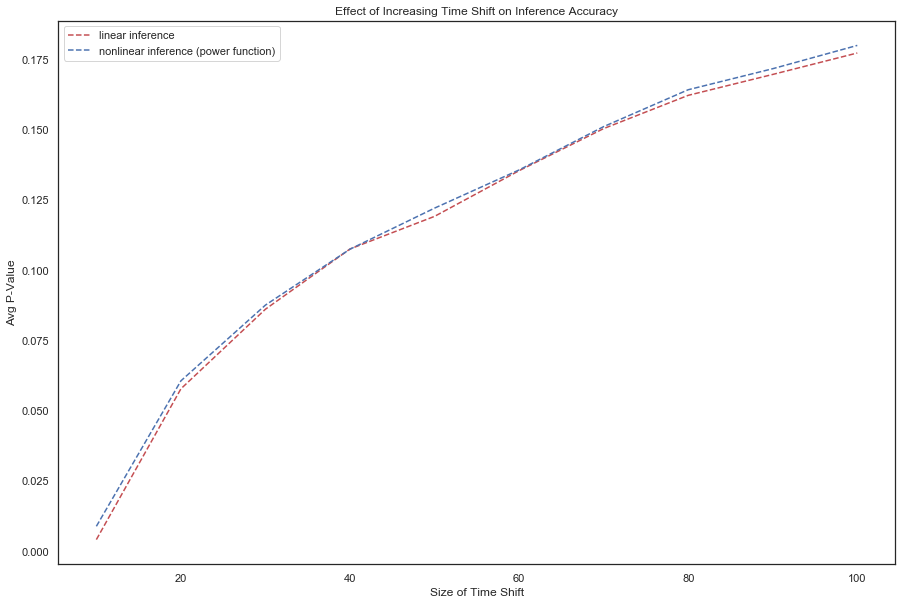

In [14]:
# plot p value by time shift here for both the linear and non linear methods
import seaborn as sns
sns.set(style='white', context='notebook', rc={'figure.figsize':(15,10)})
f = plt.figure()
plt.title('Effect of Increasing Time Shift on Inference Accuracy')
plt.xlabel('Size of Time Shift')
plt.ylabel('Avg P-Value')
plt.plot(timeshifts, pvalue_bytimeshift, 'r--', label='linear inference')
plt.plot(timeshifts, pvalue_bytimeshift_nl, 'b--', label='nonlinear inference (power function)')
plt.legend(loc = 'upper left')
plt.show()
f.savefig("linvnonlin_4.pdf", bbox_inches='tight')

In [ ]:
# plot p value by time shift here for both the linear and non linear methods
plt.plot(timeshifts, pvalue_linear_bytimeshift, 'r--')
plt.plot(timeshifts, pvalue_nonlinear_bytimeshift, 'b--')
plt.show()

In [ ]:
# allwmatrices is a dictionary with patient identifiers as keys. allwmatrices[key] will return the w matrix 
# for that specific patient
slope_average = 0
pvalue_nonlinear_average = 0
counter = 0
for patient in allwmatrices:
    w = allwmatrices[patient]
    sig = allsigs[patient]
    bias = allbiases[patient]
    
    w2 = allwmatrices2[patient]
    sig2 = allsigs2[patient]
    bias2 = allbiases2[patient]

    x_original = pca_data_dict[patient].T.copy()

    # simulate MEG timecourse data using the w, sigma, and bias computed from the inference code
    simulated_data = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, power=1, bias=bias)
    
    simulated_data2 = simulate(pca_components, 1018, w=w2, sigma=sig2, rho=0, power=3, bias=bias2)

    # compute the time shift covariance matrices for the 'original' (transformed PCA MEG timecourse) and simulated data
    tsc_original = time_shift_cov(x_original, shift=10)
    tsc_simulated = time_shift_cov(simulated_data[0], shift=10)
    tsc_simulated2 = time_shift_cov(simulated_data2[0], shift=10)

    line_object = linregress(tsc_original, tsc_simulated)
    line_object2 = linregress(tsc_original, tsc_simulated2)
    plt.title('Patient ' + str(patient))
    plt.xlabel('time_shift_cov original')
    plt.ylabel('time_shift_cov simulated')
    plt.plot(tsc_original, tsc_simulated, 'ro', alpha=0.5)
    plt.plot(tsc_original, tsc_simulated2, 'bo', alpha=0.5)
    
    time_shift_axes = np.arange(-1, 2)
    plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'r--')
    plt.plot(time_shift_axes, (line_object2.slope*time_shift_axes)+line_object2.intercept, 'b--')
    
    plt.plot([-1, 1], [-1,1], 'g--')
    plt.show()

In [ ]:
for patient in allwmatrices2:
    w = allwmatrices[patient]
    sig = allsigs[patient]
    bias = allbiases[patient]

    x_original = pca_data_dict[patient].T.copy()

    # simulate MEG timecourse data using the w, sigma, and bias computed from the inference code
    simulated_data = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, bias=bias, power=1)
    w_simulated, sig_simulated, bias_simulated = infer(simulated_data[0], power=power)
    
    line_object = linregress(w, w_simulated)
    plt.title('Patient ' + str(patient))
    plt.xlabel('W matrix original')
    plt.ylabel('W matrix simulated')
    plt.plot(w, w_simulated, 'ko', alpha=0.5)
    plt.plot([-1, 1], [-1,1], 'r--')
    time_shift_axes = np.arange(-1, 2)
    plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--')
    plt.show()
    print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
    print("--------------------------------------------------------------")

In [ ]:
#try to quantify pvalue cutoffs for certain time shifts

#run pca on the first 2-3 components of the W matrices
pca_wmatrices = []
for patient in allwmatrices2:
    print(allwmatrices2[patient].shape)
    pca_wmatrices.append(allwmatrices2[patient].flatten())

In [ ]:
np.matrix(pca_wmatrices).shape

In [ ]:
pca_w = PCA(n_components=10)
pca_w.fit(np.matrix(pca_wmatrices))
transformed_data_w = pca_w.fit_transform(np.matrix(pca_wmatrices))

In [ ]:
pca_tscmatrices = []
for patient in pca_data_dict:
    pca_tscmatrices.append(time_shift_cov(pca_data_dict[patient].T, shift=40).flatten())

In [ ]:
pca_tsc = PCA(n_components=10)
pca_tsc.fit(np.matrix(pca_wmatrices))
transformed_data_tsc = pca_tsc.fit_transform(np.matrix(pca_tscmatrices))

In [ ]:
transformed_data_w.shape

In [ ]:
# Cluster the wmatrices using spectral clustering
from sklearn.cluster import SpectralClustering
from scipy import stats
import numpy as np
from itertools import cycle, islice
clustering_w = SpectralClustering(assign_labels="discretize",
             random_state=0).fit(transformed_data_w)
# clustering = SpectralClustering(assign_labels="kmeans").fit(flattened_wmatrix_array)

cluster_dict_w = {}
counter = 0
for grouping in clustering_w.labels_:
    if grouping not in cluster_dict_w:
        cluster_dict_w[grouping] = [dataset_ids[counter]]
    else:
        cluster_dict_w[grouping].append(dataset_ids[counter])
    counter = counter + 1

for key in cluster_dict_w:
    print("Number of Patients in Cluster", key, ":", len(cluster_dict_w[key]))
    
cluster_number = len(cluster_dict_w.keys())

In [ ]:
# Cluster the wmatrices using spectral clustering
from sklearn.cluster import SpectralClustering
from scipy import stats
import numpy as np
from itertools import cycle, islice
clustering_tsc = SpectralClustering(assign_labels="discretize",
             random_state=0).fit(transformed_data_tsc)
# clustering = SpectralClustering(assign_labels="kmeans").fit(flattened_wmatrix_array)

cluster_dict_tsc = {}
counter = 0
for grouping in clustering_tsc.labels_:
    if grouping not in cluster_dict_tsc:
        cluster_dict_tsc[grouping] = [dataset_ids[counter]]
    else:
        cluster_dict_tsc[grouping].append(dataset_ids[counter])
    counter = counter + 1

for key in cluster_dict_tsc:
    print("Number of Patients in Cluster", key, ":", len(cluster_dict_tsc[key]))
    
cluster_number = len(cluster_dict_tsc.keys())

In [ ]:
clustering_w.labels_

In [ ]:
plt.scatter(transformed_data_w[:, 0], transformed_data_w[:, 1], c=clustering_w.labels_, s=50, cmap='Spectral')

In [ ]:
pvalue_avg = []
rvalue_avg = []
for patient in cluster_dict_w[1]:
    w = allwmatrices2[patient]
    sig = allsigs2[patient]
    bias = allbiases2[patient]
    simulated_patient = np.zeros((1018, pca_components))
    
    for i in range(100):
        simulated_patient_temp = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, bias=bias, power=3)
        simulated_patient += simulated_patient_temp[0]
    simulated_patient = simulated_patient/20
    
    tsc_original = time_shift_cov(pca_data_dict[patient].T, shift=50)
    tsc_simulated = time_shift_cov(simulated_patient, shift=50)
    
    line_object = linregress(tsc_original, tsc_simulated)
    plt.title('Patient ' + str(patient))
    plt.xlabel('time_shift_cov original')
    plt.ylabel('time_shift_cov simulated')
    plt.plot(tsc_original, tsc_simulated, 'ro', alpha=0.5)
    
    time_shift_axes = np.arange(-1, 2)
    plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'r--')
    
    plt.plot([-1, 1], [-1,1], 'g--')
    plt.show()
    plt.close()
    print(line_object.pvalue)
    print(line_object.rvalue)
    pvalue_avg.append(line_object.pvalue)
    rvalue_avg.append(line_object.rvalue)

print('mean p', np.mean(pvalue_avg))
print('std p', np.std(pvalue_avg))
print()
print('mean r', np.mean(rvalue_avg))
print('std r', np.std(rvalue_avg))


In [ ]:
pvalue_avg = []
rvalue_avg = []
for patient in cluster_dict_tsc[7]:
    w = allwmatrices2[patient]
    sig = allsigs2[patient]
    bias = allbiases2[patient]
    
    
    simulated_patient = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, bias=bias, power=3)
    tsc_original = time_shift_cov(pca_data_dict[patient].T, shift=40)
    tsc_simulated = time_shift_cov(simulated_patient[0], shift=40)
    
    line_object = linregress(tsc_original, tsc_simulated)
    plt.title('Patient ' + str(patient))
    plt.xlabel('time_shift_cov original')
    plt.ylabel('time_shift_cov simulated')
    plt.plot(tsc_original, tsc_simulated, 'ro', alpha=0.5)
    
    time_shift_axes = np.arange(-1, 2)
    plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'r--')
    
    plt.plot([-1, 1], [-1,1], 'g--')
    plt.show()
    plt.close()
    print(line_object.pvalue)
    print(line_object.rvalue)
    pvalue_avg.append(line_object.pvalue)
    rvalue_avg.append(line_object.rvalue)

print('mean p', np.mean(pvalue_avg))
print('std p', np.std(pvalue_avg))
print()
print('mean r', np.mean(rvalue_avg))
print('std r', np.std(rvalue_avg))

In [ ]:
plt.scatter(transformed_data_w[:, 0], transformed_data_w[:, 1], c=clustering_tsc.labels_, s=50, cmap='Spectral')

In [ ]:
cluster_dict_w

In [ ]:
#try to quantify pvalue cutoffs for certain time shifts

#run pca on the first 2-3 components of the W matrices
pca_tscmatrices = []
for patient in pca_data_dict:
    pca_tscmatrices.append(time_shift_cov(pca_data_dict[patient].T, shift=time_shift).flatten())

In [ ]:
np.matrix(pca_tscmatrices).shape

In [ ]:
pca_tsc = PCA(n_components=2)
pca_tsc.fit(np.matrix(pca_tscmatrices))
transformed_data_tsc = pca_tsc.fit_transform(np.matrix(pca_tscmatrices))

In [ ]:
transformed_data_tsc.shape

In [ ]:
plt.scatter(transformed_data_tsc[:, 0], transformed_data_tsc[:, 1], c=clustering_tsc.labels_, s=50, cmap='Spectral')

In [ ]:
plt.scatter(transformed_data_tsc[:, 0], transformed_data_tsc[:, 1], c=clustering_w.labels_, s=50, cmap='Spectral')

In [ ]:
# Cluster the wmatrices using spectral clustering
from sklearn.cluster import SpectralClustering
from scipy import stats
import numpy as np
from itertools import cycle, islice
clustering_tsc = SpectralClustering(assign_labels="discretize",
             random_state=0).fit(transformed_data_tsc)
# clustering = SpectralClustering(assign_labels="kmeans").fit(flattened_wmatrix_array)

cluster_dict_tsc = {}
counter = 0
for grouping in clustering_tsc.labels_:
    if grouping not in cluster_dict_tsc:
        cluster_dict_tsc[grouping] = [dataset_ids[counter]]
    else:
        cluster_dict_tsc[grouping].append(dataset_ids[counter])
    counter = counter + 1

for key in cluster_dict_tsc:
    print("Number of Patients in Cluster", key, ":", len(cluster_dict_tsc[key]))
    
cluster_number = len(cluster_dict_tsc.keys())

In [ ]:
#calculate the average w matrix for each cluster
avg_w_plot = {}
for key in cluster_dict_w:
    avg_w_matrix = np.zeros((pca_components, pca_components))
    count = 0
    for patient in cluster_dict_w[key]:
        avg_w_matrix += allwmatrices2[patient]
        count += 1
    avg_w_plot[key] = avg_w_matrix/count


In [ ]:
for key in avg_w_plot:
    for key2 in avg_w_plot:
        if key2 != key:
            line_object = linregress(avg_w_plot[key], avg_w_plot[key2])
            plt.title('Plot for ' + str(key) + ' and ' + str(key2))
            plt.plot(avg_w_plot[key], avg_w_plot[key2], 'ko', alpha=0.5)
            plt.plot([-1, 1], [-1,1], 'r--')
            time_shift_axes = np.arange(-1, 2)
            plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--')
            plt.show()
            plt.close()
            plt.show()
            print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
            print("--------------------------------------------------------------")

In [ ]:
for key in avg_w_plot:
    for key2 in avg_w_plot:
        if key2 != key:
            print(key, key2)
            subtract = avg_w_plot[key] - avg_w_plot[key2]
            seaborn.heatmap(subtract)
            plt.show()
            plt.close()

In [ ]:
# calculate the average tsc matrix for each cluster, and plot against each other
avg_tsc_plot = {}
for key in cluster_dict_tsc:
    avg_tsc_matrix = np.zeros((pca_components, pca_components))
    count = 0
    for patient in cluster_dict_tsc[key]:
        avg_tsc_matrix += time_shift_cov(pca_data_dict[patient].T, shift=time_shift)
        count += 1
    avg_tsc_plot[key] = avg_tsc_matrix/count

        


In [ ]:
for key in avg_tsc_plot:
    for key2 in avg_tsc_plot:
        if key2 != key:
            line_object = linregress(avg_tsc_plot[key], avg_tsc_plot[key2])
            plt.title('Plot for ' + str(key) + ' and ' + str(key2))
            plt.plot(avg_tsc_plot[key], avg_tsc_plot[key2], 'ko', alpha=0.5)
            plt.plot([-1, 1], [-1,1], 'r--')
            time_shift_axes = np.arange(-1, 2)
            plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--')
            plt.show()
            plt.close()
            plt.show()
            print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
            print("--------------------------------------------------------------")

In [ ]:
for key in avg_tsc_plot:
    for key2 in avg_tsc_plot:
        if key2 != key:
            subtract = avg_tsc_plot[key] - avg_tsc_plot[key2]
            seaborn.heatmap(subtract)
            plt.show()
            plt.close()

In [ ]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

def union(lst1, lst2):
    return list(set(lst1) | set(lst2))

In [ ]:
frequency_map = np.zeros((len(cluster_dict_w.keys()), len(cluster_dict_tsc.keys())))
for cluster in cluster_dict_w:
    for cluster2 in cluster_dict_tsc:
        if cluster2 > 2:
            frequency_map[cluster][cluster2-1] = len(intersection(cluster_dict_w[cluster], cluster_dict_tsc[cluster2]))/len(union(cluster_dict_w[cluster], cluster_dict_tsc[cluster2]))
        else:
            frequency_map[cluster][cluster2] = len(intersection(cluster_dict_w[cluster], cluster_dict_tsc[cluster2]))/len(union(cluster_dict_w[cluster], cluster_dict_tsc[cluster2]))
import seaborn
seaborn.heatmap(frequency_map, annot=True)    
plt.show()
plt.close()

In [ ]:
cluster_dict_w[1]

In [ ]:
cluster_dict_tsc[0]

In [ ]:
intersection(cluster_dict_w[1], cluster_dict_tsc[0])

In [ ]:
union(cluster_dict_w[1], cluster_dict_tsc[0])

In [ ]:
# are the same sets of patients in the same cluster groupings across time shift cov and w matrices?
for key in cluster_dict_w:
    print("Cluster", key, ":", cluster_dict_w[key])
print()
for key in cluster_dict_tsc:
    print("Cluster", key, ":", cluster_dict_tsc[key])
    
links = {}
for key in cluster_dict_w:
    for patient in cluster_dict_w[key]:
        for key2 in cluster_dict_tsc:
            for patient2 in cluster_dict_tsc[key2]:
                if patient == patient2:
                    #do something
                    links[patient] = (key, key2)
                    
# for key in cluster_dict_tsc:
#     for patient in cluster_dict_tsc[key]:
#         for key2 in cluster_dict_w:
#             for patient2 in cluster_dict_w[key2]:
#                 if patient == patient2:
#                     #do something
#                     links[patient] = (key, key2)

In [ ]:
links

In [ ]:
frequency_dict = {}
for value in links.values():
    if value not in frequency_dict:
        frequency_dict[value] = 1
    else:
        frequency_dict[value] += 1

for key in frequency_dict:
    if frequency_dict[key] >= 4 :
        print("Cluster Common Count:", key, "=", frequency_dict[key])

In [ ]:
# cluster_mapping_matrix = np.zeros((len(cluster_dict_w.keys()), len(cluster_dict_tsc.keys())))
# for key_w in cluster_dict_w:
#     for key_tsc in cluster_dict_tsc:
#         cluster_mapping_matrix[key_w][key_tsc] = len(intersection(cluster_dict_w[key_w], cluster_dict_tsc[key_tsc]))/len(union(cluster_dict_w[key_w], cluster_dict_tsc[key_tsc]))
        
# import seaborn
# seaborn.heatmap(cluster_mapping_matrix, annot=True)    
# plt.show()
# plt.close()


for num_clusters in range(4, 8):
    kmeans_labels_tsc = cluster.KMeans(n_clusters=num_clusters, random_state=42).fit_predict(flattened_tscmatrix_array)   
    kmeans_labels_w = cluster.KMeans(n_clusters=num_clusters, random_state=42).fit_predict(flattened_wmatrix_array)
    
    cluster_dict_kmeans_w = {}
    counter = 0
    for grouping in kmeans_labels_w:
        if grouping not in cluster_dict_kmeans_w:
            cluster_dict_kmeans_w[grouping] = [dataset_ids[counter]]
        else:
            cluster_dict_kmeans_w[grouping].append(dataset_ids[counter])
        counter = counter + 1

    cluster_dict_kmeans_tsc = {}
    counter = 0
    for grouping in kmeans_labels_tsc:
        if grouping not in cluster_dict_kmeans_tsc:
            cluster_dict_kmeans_tsc[grouping] = [dataset_ids[counter]]
        else:
            cluster_dict_kmeans_tsc[grouping].append(dataset_ids[counter])
        counter = counter + 1
     
    cluster_mapping_matrix = np.zeros((len(cluster_dict_kmeans_w.keys()), len(cluster_dict_kmeans_tsc.keys())))
    for key_w in cluster_dict_kmeans_tsc:
        for key_tsc in cluster_dict_kmeans_tsc:
            cluster_mapping_matrix[key_w][key_tsc] = len(intersection(cluster_dict_kmeans_w[key_w], cluster_dict_kmeans_tsc[key_tsc]))/len(union(cluster_dict_kmeans_w[key_w], cluster_dict_kmeans_tsc[key_tsc]))
    
    import seaborn
    seaborn.heatmap(cluster_mapping_matrix, annot=True)    
    plt.show()
    plt.close()

# Separator

In [ ]:
pca_wmatrix_dictionary = {}
counter = 0
for patient in allwmatrices2:
    pca_wmatrix_dictionary[patient] = transformed_data_w[counter*10:10*(counter+1), :].T
    counter = counter + 1

In [ ]:
pca_wmatrix_dictionary

In [ ]:
# spectral clustering, spectrally cluster the W matrices of all the patients to see if certain patients fall into 
# certain categories. Do for all 88 patients

# prepare a matrix to input into the spectral clustering function, must flatten all the W matrices
def wmatrix_clustering_prepare(allwmatrices):
    flattened_wmatrix_array = []
    unflattened_wmatrix_dict = {}
    counter = 0
    for patient in allwmatrices:
        flattened_matrix = allwmatrices[patient].flatten()
        unflattened_wmatrix_dict[counter] = allwmatrices[patient]
        if len(flattened_wmatrix_array) == 0:
            flattened_wmatrix_array = [flattened_matrix]
        else:
            flattened_wmatrix_array.append(flattened_matrix)
        counter = counter + 1
    return flattened_wmatrix_array, unflattened_wmatrix_dict

flattened_wmatrix_array, unflattened_wmatrix_dict = wmatrix_clustering_prepare(pca_wmatrix_dictionary)

# Cluster the wmatrices using spectral clustering
from sklearn.cluster import SpectralClustering
from scipy import stats
import numpy as np
from itertools import cycle, islice
clustering_w = SpectralClustering(assign_labels="discretize",
             random_state=0).fit(flattened_wmatrix_array)
# clustering = SpectralClustering(assign_labels="kmeans").fit(flattened_wmatrix_array)

cluster_dict_w = {}
counter = 0
for grouping in clustering_w.labels_:
    if grouping not in cluster_dict_w:
        cluster_dict_w[grouping] = [dataset_ids[counter]]
    else:
        cluster_dict_w[grouping].append(dataset_ids[counter])
    counter = counter + 1

for key in cluster_dict_w:
    print("Number of Patients in Cluster", key, ":", len(cluster_dict_w[key]))
    
cluster_number = len(cluster_dict_w.keys())

In [ ]:
import umap
from sklearn.datasets import load_digits

standard_embedding_w = umap.UMAP(random_state=42).fit_transform(np.matrix(flattened_wmatrix_array))
w_embedded = TSNE(n_components=2, random_state=42).fit_transform(flattened_wmatrix_array)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='white', context='notebook', rc={'figure.figsize':(8,8)})
plt.scatter(standard_embedding_w[:, 0], standard_embedding_w[:, 1], c=clustering_w.labels_, s=100, cmap='Spectral');
plt.show()
plt.close()

plt.scatter(w_embedded[:, 0], w_embedded[:, 1], c=clustering_w.labels_, s=100, cmap='Spectral');
plt.show()
plt.close()

In [ ]:
from sklearn.manifold import TSNE
sns.set(style='white', context='notebook', rc={'figure.figsize':(8,8)})

w_embedded = TSNE(n_components=2, random_state=42).fit_transform(flattened_wmatrix_array)

import sklearn.cluster as cluster
kmeans_labels_w = cluster.KMeans(n_clusters=8, random_state=42).fit_predict(flattened_wmatrix_array)

plt.scatter(standard_embedding_w[:, 0], standard_embedding_w[:, 1], c=kmeans_labels_w, s=100, cmap='Spectral');
plt.show()
plt.close()

plt.scatter(w_embedded[:, 0], w_embedded[:, 1], c=kmeans_labels_w, s=100, cmap='Spectral');
plt.show()
plt.close()

In [ ]:
print(kmeans_labels_w)